Data is processed in a local environment for now. For a cloud based environment, do the following"
-involvement_columns.csv to extract features of interest
-feature_weights.csv to extract feature weights
-team_activity..csv to extract feature evaluation statistics

There is no implementation for numerical values as of now. Code can be modified to accept both types of data

In [9]:
# Preprocessing
import pandas as pd

# Load and transpose the team activity data
team_activity_file_path = 'data/team_activity.csv'
team_activity_df = pd.read_csv(team_activity_file_path, index_col=0).transpose()

# Define the mapping from qualitative descriptions to numerical values
involvement_mapping = {
    'Strong': 3,
    'Good': 2,
    'Average': 1,
    'None': 0
}

# Define involvement columns

involvement_columns = ['Funding', 'Application-Oriented', 'Demos', 'Industrial Collaborations', 'System Maturity', 'Number of Members', 'Academic Collaborations']

# Convert qualitative descriptions to numerical values
for column in involvement_columns:
    if column in team_activity_df.columns:
        team_activity_df[column] = team_activity_df[column].map(involvement_mapping).fillna(0)

# Define feature weights
feature_weights = {
    'Demos': 5,
    'Industrial Collaborations': 5,
    'Academic Collaborations': 3,
    'Application-Oriented': 3,
    'System Maturity': 2,
    'Funding': 1,
    'Number of Members': 1,
}


In [10]:
# Calculate performance scores based on the mapping and weights
def calculate_performance_score(row, weights):
    
    """
    Calculate a performance score for a given row based on the feature values and their corresponding weights.

    Parameters:
    - row (Series): A row of data from the DataFrame.
    - weights (dict): A dictionary where keys are feature names and values are the weights for those features.

    Returns:
    - score (int): The calculated performance score for the row.
    """
    score = 0
    for feature, weight in weights.items():
        if feature in row:
            score += row[feature] * weight
    return score

team_activity_df['Performance Score'] = team_activity_df.apply(calculate_performance_score, axis=1, weights=feature_weights)

# Reset index to have 'Team' as a column
team_activity_df.reset_index(inplace=True)
team_activity_df.rename(columns={'index': 'Team'}, inplace=True)

# Display the updated DataFrame
print(team_activity_df.head())

Team    Team  Funding  Application-Oriented  Number of Members  \
0       DICE      1.0                   2.0                  1   
1     MagICL      3.0                   3.0                  3   
2     BioHIT      3.0                   3.0                  2   
3       CAKT      3.0                   3.0                  2   
4        CER      2.0                   2.0                  3   

Team  Academic Collaborations  System Maturity  Demos  \
0                         2.0              2.0    2.0   
1                         3.0              3.0    3.0   
2                         2.0              2.0    2.0   
3                         3.0              3.0    3.0   
4                         0.0              3.0    3.0   

Team  Industrial Collaborations  Performance Score  
0                           1.0               33.0  
1                           3.0               60.0  
2                           1.0               39.0  
3                           3.0               59

In [21]:
team_activity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Team                       14 non-null     object 
 1   Funding                    14 non-null     float64
 2   Application-Oriented       14 non-null     float64
 3   Number of Members          14 non-null     int64  
 4   Academic Collaborations    14 non-null     float64
 5   System Maturity            14 non-null     float64
 6   Demos                      14 non-null     float64
 7   Industrial Collaborations  14 non-null     float64
 8   Performance Score          14 non-null     float64
dtypes: float64(7), int64(1), object(1)
memory usage: 1.1+ KB


In [11]:
# Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

scaler = StandardScaler()

# Define features for clustering
features_c = [col for col in team_activity_df.columns if col not in ['Performance Score', 'Team']]
X = team_activity_df[features_c]


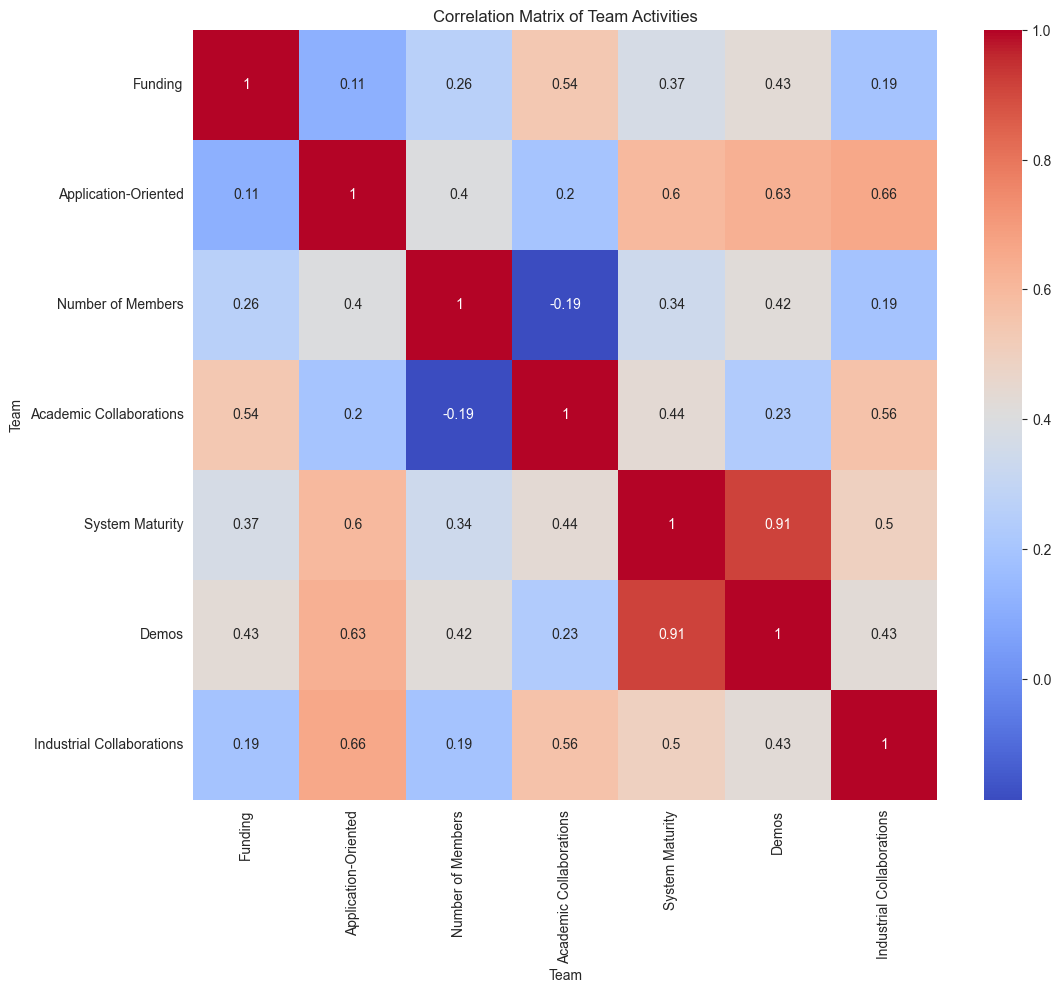

In [12]:
import seaborn as sns

# Compute the correlation matrix
corr = team_activity_df[features_c].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Team Activities')
plt.show()


In [ ]:
!pip install statsmodels

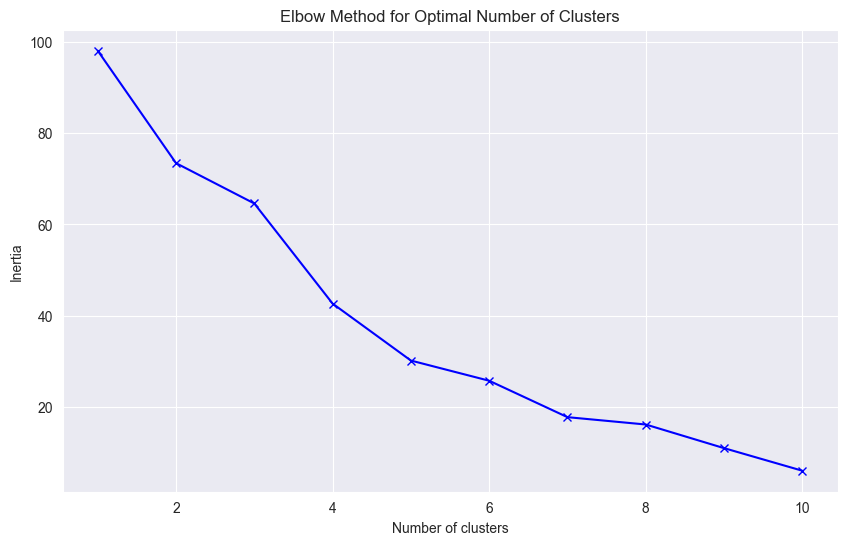

In [13]:
X_scaled = scaler.fit_transform(X)

# Determine the optimal number of clusters using the Elbow method
def plot_elbow_method(X):
    
    """
    Plots the Elbow method graph to help determine the optimal number of clusters.

    Parameters:
    - X (array-like): Scaled feature set to be used for clustering.

    Returns:
    - None
    """
    inertia = []
    K = range(1, 11)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(K, inertia, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.show()

plot_elbow_method(X_scaled)

# Apply clustering with an optimal number of clusters
num_clusters = 5  # Update this based on the Elbow method result
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
team_activity_df['Cluster'] = kmeans.fit_predict(X_scaled)


In [14]:

# Display the updated DataFrame with clusters
print(team_activity_df.head())

Team    Team  Funding  Application-Oriented  Number of Members  \
0       DICE      1.0                   2.0                  1   
1     MagICL      3.0                   3.0                  3   
2     BioHIT      3.0                   3.0                  2   
3       CAKT      3.0                   3.0                  2   
4        CER      2.0                   2.0                  3   

Team  Academic Collaborations  System Maturity  Demos  \
0                         2.0              2.0    2.0   
1                         3.0              3.0    3.0   
2                         2.0              2.0    2.0   
3                         3.0              3.0    3.0   
4                         0.0              3.0    3.0   

Team  Industrial Collaborations  Performance Score  Cluster  
0                           1.0               33.0        4  
1                           3.0               60.0        2  
2                           1.0               39.0        4  
3           

In [15]:
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np

# Visualize individual team performance
def plot_individual_performance(df):
    
     
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Team', y='Performance Score', hue='Team', data=df, palette='viridis', dodge=False, legend=False)
    plt.title('Team Performance Scores')
    plt.xlabel('Team')
    plt.ylabel('Performance Score')
    plt.xticks(rotation=45)
    plt.show()

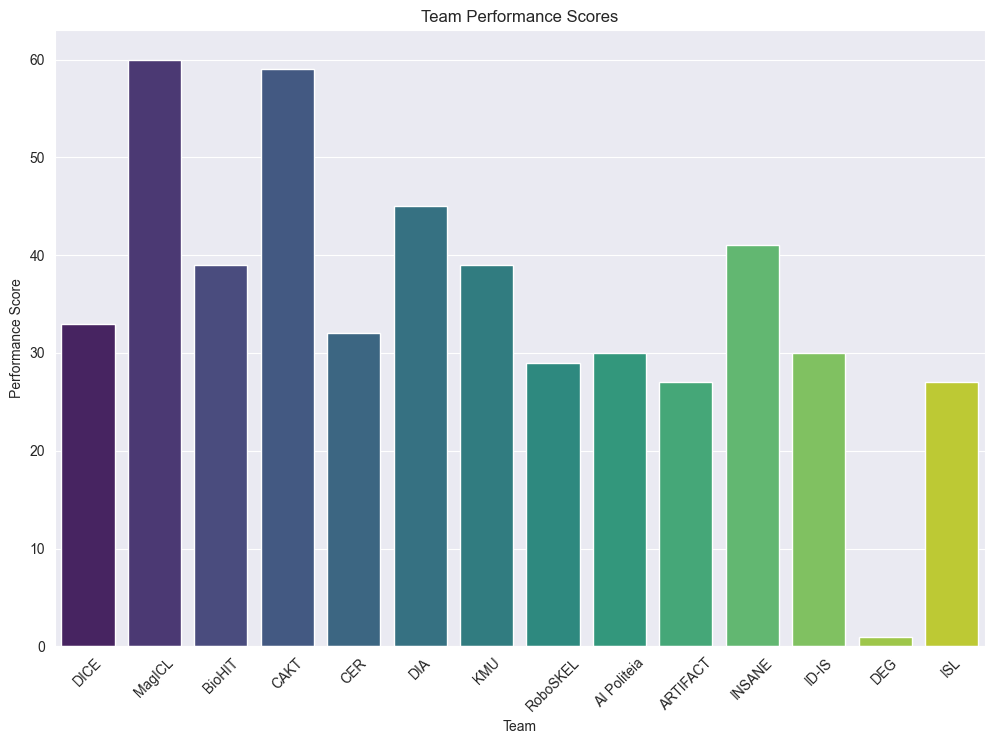

In [16]:
plot_individual_performance(team_activity_df)

In [17]:
# Visualize overall performance distribution
def plot_performance_distribution(df):
    """
    Plots a histogram of performance scores with a kernel density estimate (KDE).

    Parameters:
    - df (DataFrame): The DataFrame containing the team activity data and performance scores.

    Returns:
    - None
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Performance Score'], kde=True, color='blue')
    plt.title('Performance Score Distribution')
    plt.xlabel('Performance Score')
    plt.ylabel('Frequency')
    plt.show()

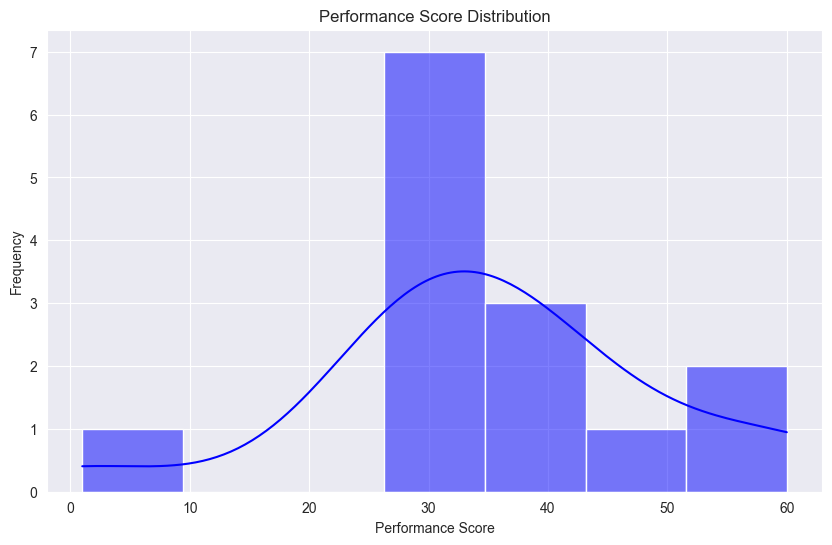

In [18]:
plot_performance_distribution(team_activity_df)

In [30]:
# Visualize cluster distribution
def plot_cluster_distribution(df):
    
    """
    Plots a scatter plot of performance scores for each team, colored by cluster.

    Parameters:
    - df (DataFrame): The DataFrame containing the team activity data, performance scores, and cluster labels.

    Returns:
    - None
    """
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='Team', y='Performance Score', hue='Cluster', data=df, palette='viridis')
    plt.title('Cluster Distribution')
    plt.xlabel('Team')
    plt.ylabel('Performance Score')
    plt.xticks(rotation=45)
    plt.legend(title='Cluster')
    plt.show()

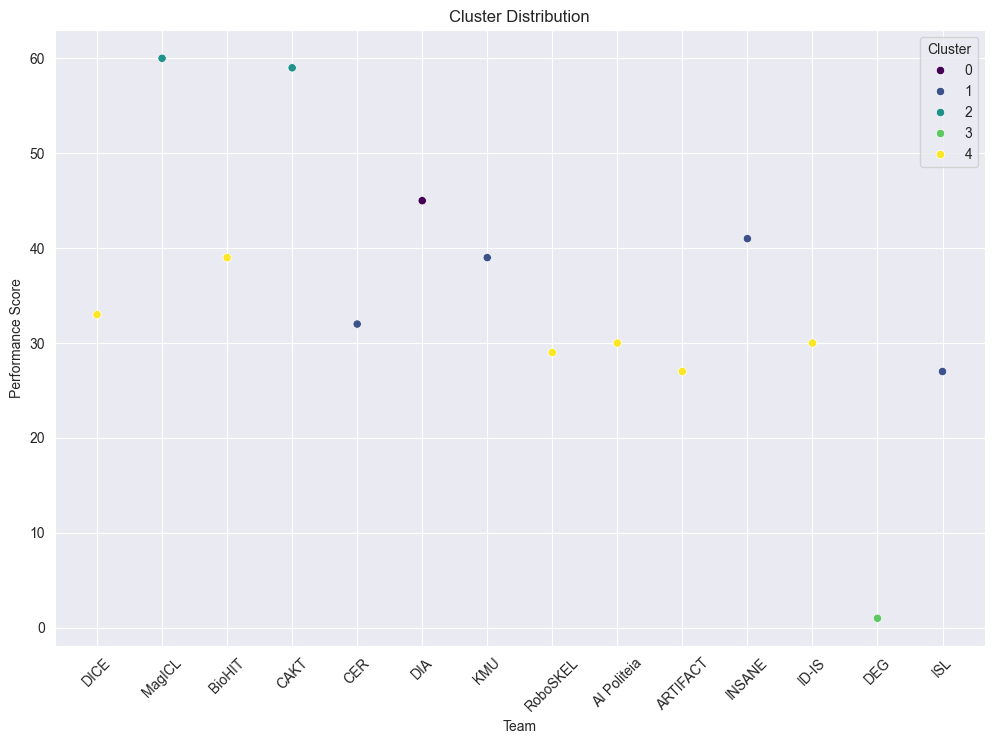

In [12]:
plot_cluster_distribution(team_activity_df)

In [13]:
#Cluster assignment table

cluster_assignment_table = team_activity_df[['Team','Cluster']]
cluster_assignment_table

Team,Team,Cluster
0,DICE,4
1,MagICL,2
2,BioHIT,4
3,CAKT,2
4,CER,1
5,DIA,0
6,KMU,1
7,RoboSKEL,4
8,AI Politeia,4
9,ARTIFACT,4


In [19]:
# PCA visualization
def plot_pca(df, features):
    
    """
    Plots a 2D PCA (Principal Component Analysis) visualization of the given features in the DataFrame.

    Parameters:
    - df (DataFrame): The DataFrame containing the team activity data and cluster labels.
    - features (list): A list of feature names to include in the PCA analysis.

    Returns:
    - None
    """
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(df[features])
    
    df['PCA1'] = pca_results[:, 0]
    df['PCA2'] = pca_results[:, 1]
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df, palette='viridis')
    plt.title('PCA Visualization')
    plt.show()

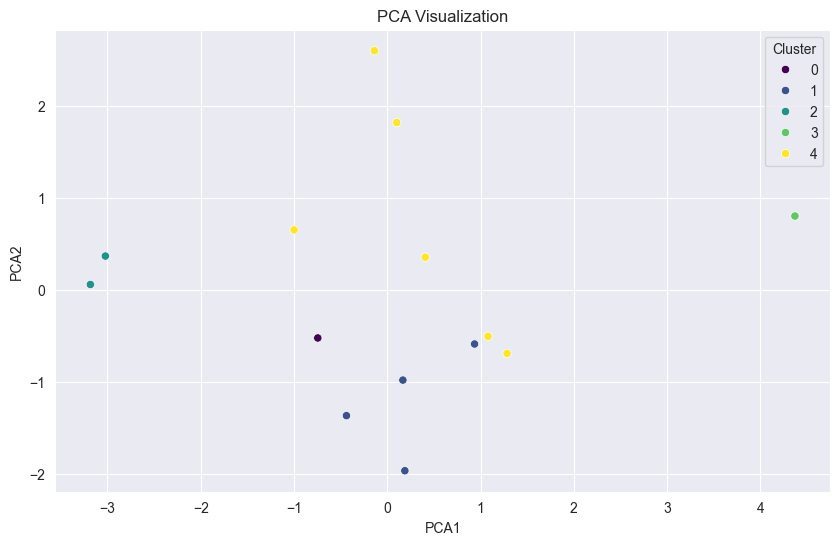

In [20]:
plot_pca(team_activity_df, features_c)

In [21]:
# Box plot for comparing feature distributions across clusters
def plot_cluster_box_plots(df, features):
    for feature in features:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Cluster', y=feature, data=df, legend = False, hue = 'Cluster')
        plt.title(f'{feature} Distribution by Cluster')
        plt.show()

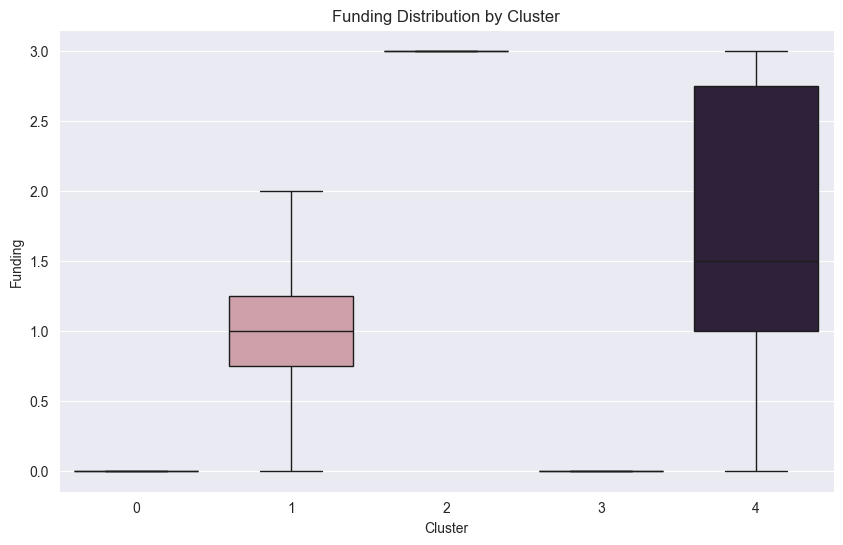

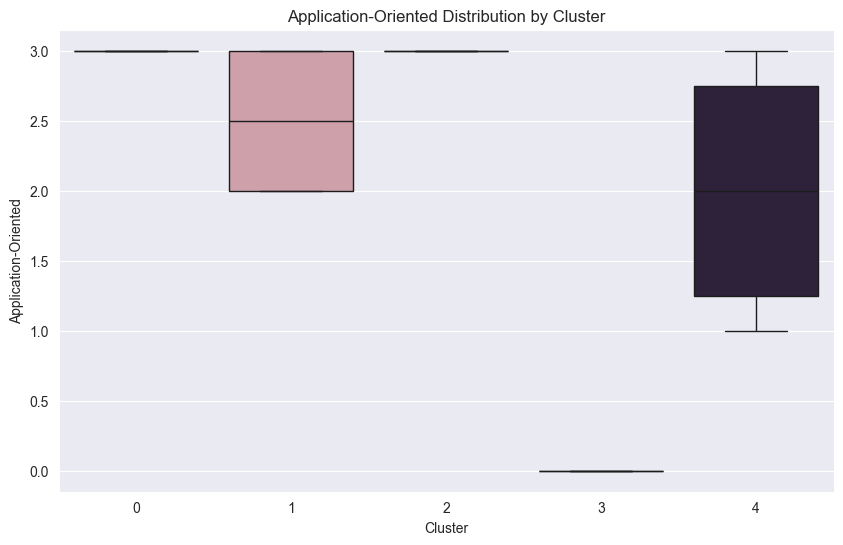

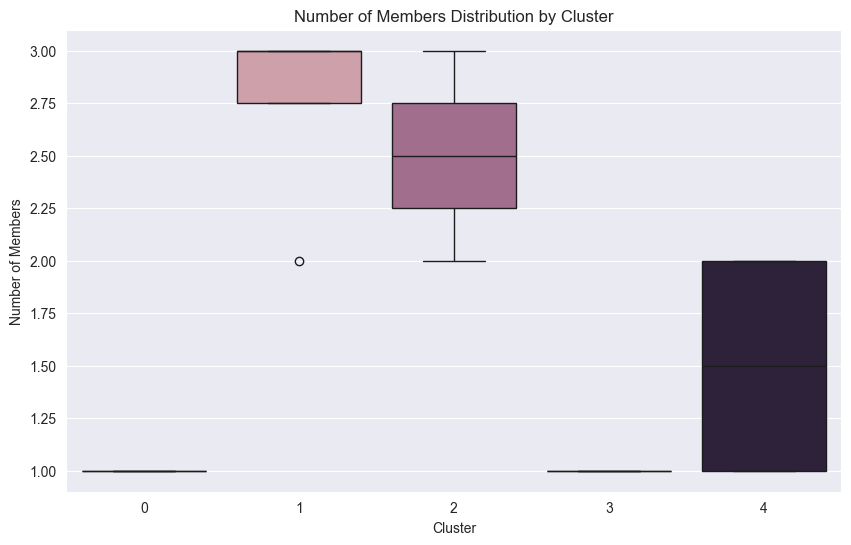

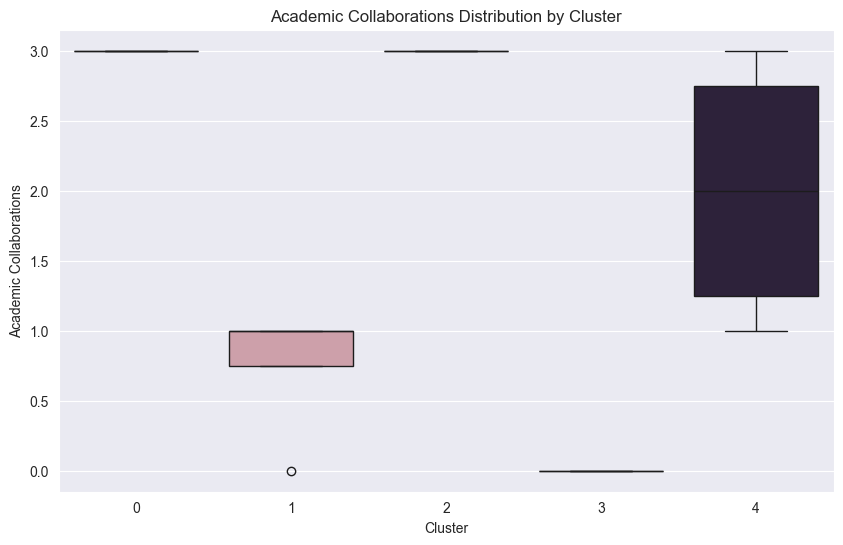

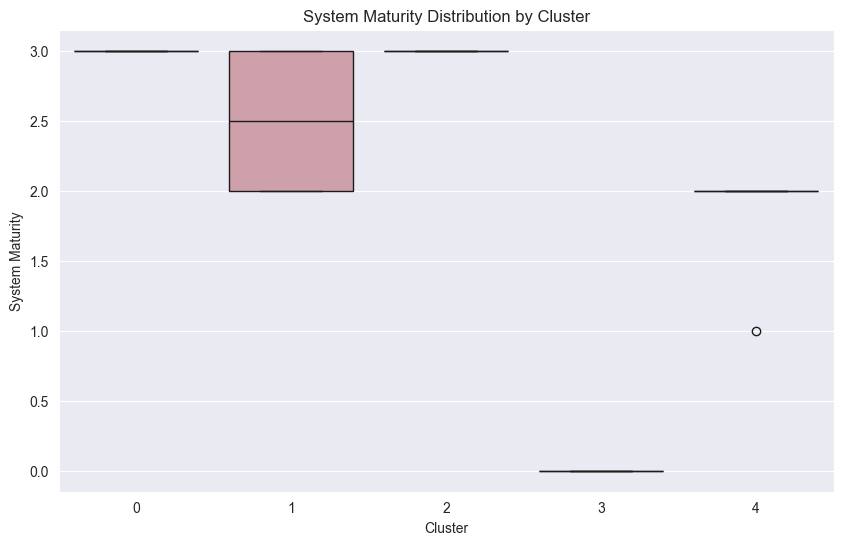

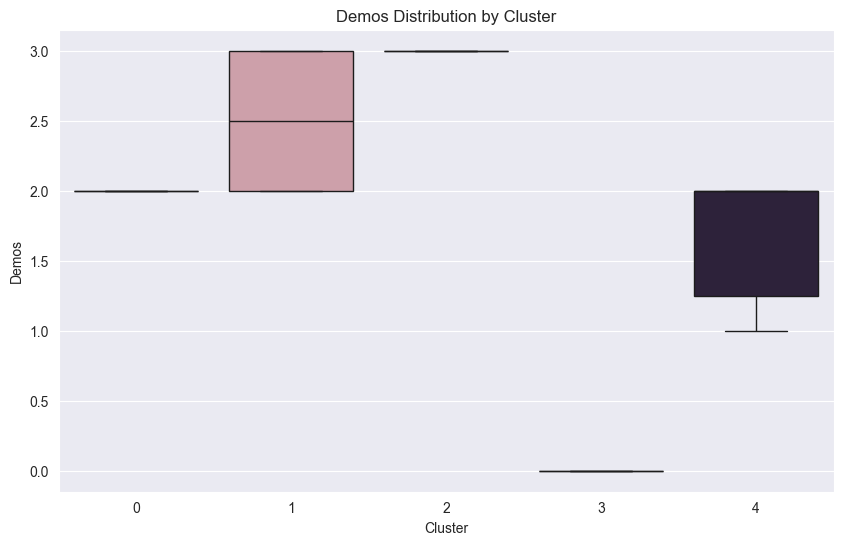

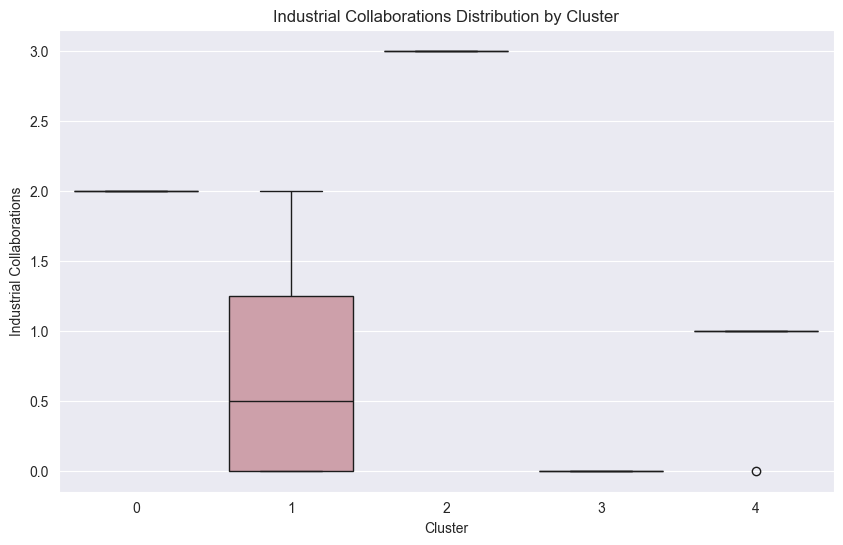

In [22]:
plot_cluster_box_plots(team_activity_df, features_c)